# PA005: High Value Customer Identification

Na cor preta: o que foi desenvolvido no ciclo. 


Na cor vermelha: o que não foi desenvolvido no ciclo ou que foi feito o mínimo necessário para gerar um resultado inicial no projeto.

# 0.0 Imports

In [1]:
# Biblioteca para manipulação dos dataframes
import pandas   as pd 
# Biblioteca para trabalhar com vetores e arrays
import numpy    as np

# Bibliotecas para trabalhar com Gráficos
import seaborn  as sns
from matplotlib import pyplot  as plt 
from plotly import express as px 

# Biblioteca para configurar layout tela Jupyter
from IPython.core.display import HTML

# Biblioteca para alterar nome das colunas de Kamel Case para Snake Case
import inflection

# Biblioteca para implementar e avaliar algoritmos 
from sklearn import cluster as ct
from sklearn import metrics as mt
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

import plotly.graph_objs as go

# Biblioteca para redução de dimensionalidade dos dados
import umap.umap_ as umap

C:\Users\alanc\anaconda3\envs\insiders_clustering\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\alanc\anaconda3\envs\insiders_clustering\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\alanc\anaconda3\envs\insiders_clustering\lib\site-pac

## 0.1 Helper functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 10
    display( HTML( '<style>.container { width:97% !important; }</style>') )
    pd.options.display.max_columns = 50
    pd.options.display.max_rows = 50
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    
    return None

jupyter_settings()

## 0.2 Load Dataset

In [3]:
# load data
df_raw = pd.read_csv('C:/Users/alanc/Documents/repos/insiders_clustering/data/raw/ecommerce.csv', encoding = 'unicode_escape' )

# drop extra column
df_raw.drop(columns = ['Unnamed: 8'], inplace = True)

In [4]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.550,17850.000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.390,17850.000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.750,17850.000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.390,17850.000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.390,17850.000,United Kingdom


#  1.0 Descrição dos dados 

In [4]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df1 = df_raw.copy()

## 1.1. Rename Columns

Ter o nome das colunas de maneira mais intuitiva para trabalhar com ciência de dados

In [27]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [5]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
            'UnitPrice', 'CustomerID', 'Country']

## Utiliza função lambda para encapsular a função que transforma para snake_case os atributos
snakecase = lambda x: inflection.underscore( x )

## Map - Mapeia cada valor dentro da estrutura de dado passada e aplica a função snakecase
cols_new = list( map( snakecase, cols_old ) )

## rename 
df1.columns = cols_new

In [29]:
df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

## 1.2 Columns Meanings

Objetivo é compreender o significado de cada coluna 

- **invoice_no:** identificador único de cada transação;


- **stock_code:** código do item;


- **description:** nome do item;


- **quantity:** quantidade de cada item comprado por transação;	


- **invoice_data:** data em que a transação ocorreu;


- **unit_price:** preço unitário do produto;


- **customer_id:** identificador único do cliente;


- **country:** país que o cliente reside.

## 1.3. Data Dimensions

Analisar a dimensão dos dados a serem trabalhados

In [30]:
print(f"Número de linhas: {df1.shape[0]}")
print(f"Número de colunas: {df1.shape[1]}")

Número de linhas: 541909
Número de colunas: 8


## 1.4. Data Types

Verificar se os tipos de dados correspondem corretamente a informação que as colunas estão apresentando 

In [31]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.5. Check NA

Verificar a existência de valores nulos 

In [37]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## <font color = 'red'> 1.6.  Fillout NA </font>

Tratar os valores nulos  

In [6]:
## Tratar da maneira mais simples primeiramente -> remover na
df1.dropna( subset = ['description','customer_id'], inplace = True )

print("Dados Removidos: {:.2f}%".format( (1 - (df1.shape[0]/df_raw.shape[0]) )*100  ) )

Dados Removidos: 24.93%


In [7]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.7. Change Data Types

 

In [52]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [10]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.550,17850.000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.390,17850.000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.750,17850.000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.390,17850.000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.390,17850.000,United Kingdom


In [8]:
# arrumar coluna para ficar com tipo de dado de date 
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

# passar coluna de float64 -> int64, não tem necessidade de ser float 
df1['customer_id'] = df1['customer_id'].astype('int64')

In [9]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

In [11]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.550,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.390,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.750,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.390,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.390,17850,United Kingdom


## <font color = 'red'> 1.8. Descriptive Statistical </font>


Resumo Geral dos dados com o objetivo de compreender comportamento , outliers e anormalidades nos valores dos atributos.

### 1.8.1. Numerical Attributes

### 1.8.2. Categorical Attributes

#  2.0 Feature Engineering 

O objetivo é criar/ajustar atributos por meio dos já existentes os quais possam ser relevantes para explicar o fenômeno de análise.

In [10]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df2 = df1.copy()

## 2.1. Creation Features

- Ciclo 1: Criar features RFM (Recency, Frequency, Monetary);
- Ciclo 2: Criar feature Ticket Médio

In [18]:
# Estratégia

# 0. Arrumar granularidade (menor nível de detalhamento dos dados) do conjunto de dados em um dataframe novo; 
# 1. Calcular features que desejo para os clientes (Recency, Frequency, Monetary)
#     1.1. Monetary: gross_revenue = quantity * unit_price para cada linha da base atual
#     1.2. Faturamento (gross_revenue_total) p/ cliente = Agrupar clientes da base e somar o revenue durante todo o período disponível na base

#     1.3. Recency: agrupo datas de compra por cliente e filtro a mais recente 
#     1.4. Tempo em dias desde a última compra do cliente = Data mais recente no histórico e subtrair da data de compra mais recente de cada cliente

#     1.5. Frequency: Agrupar clientes da base e somar a quantidade total de compras(transações) durante todo o período disponível na base 

# CICLO 2
#     1.6. Average Ticket: agrupar clientes e calcular a média da receita gerada para cada cliente  
df2.head()   

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.550,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.390,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.750,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.390,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.390,17850,United Kingdom


- Conjunto de dados originalmente é detalhado em produtos por transação;


- A chave primária de cada amostra/obs. (granularidade) do conjunto de dados é o conjunto ( invoice_no (transação) | stock_code (produtos) )  pois é o que varia;


- Transações diferentes no mesmo dia podem ter clientes iguais;


- O objetivo é ajustar a granularidade da tabela por cliente, colocando as features que me interessam para realizar a clusterização.

In [11]:
## MONETARY ------------------------------------------------

# 1.1 

df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

# 0 e 1.2

df_ref = df2[['gross_revenue', 'customer_id']].groupby(by = 'customer_id').sum().reset_index().rename(columns = {'gross_revenue':'gross_revenue_total'})

## RECENCY ------------------------------------------------

# 1.3 

df_recency = df2[['customer_id','invoice_date']].groupby(by = 'customer_id').max().reset_index()

#1.4

df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days

# Preparar para juntar com dados referencia

df_recency.drop(columns = 'invoice_date', inplace = True)

# unir com dados referencia 

df_ref = pd.merge(df_ref, df_recency, on = 'customer_id', how = 'left')

## FREQUENCY ------------------------------------------------

#1.5

df_frequency = df2[['customer_id','invoice_no']].groupby(by = 'customer_id').nunique().reset_index().rename(columns = {'invoice_no':'frequency_total'})

# unir frequencia com conjunto de dados referencia 

df_ref = pd.merge(df_ref, df_frequency, on = 'customer_id', how = 'left')


## CICLO 2
## AVG TICKET ------------------------------------------------

#1.5

df_avg_ticket = df2[['customer_id','gross_revenue']].groupby(by = 'customer_id').mean().reset_index().rename(columns = {'gross_revenue':'avg_ticket_total'})

# unir com conjunto de dados referencia 

df_ref = pd.merge(df_ref, df_avg_ticket, on = 'customer_id', how = 'left')

df_ref.head()

,customer_id,gross_revenue_total,recency_days,frequency_total,avg_ticket_total
0,12346,0.000,325,2,0.000
1,12347,4310.000,2,7,23.681
2,12348,1797.240,75,4,57.975
3,12349,1757.550,18,1,24.076
4,12350,334.400,310,1,19.671


- Conjunto de dados desenvolvido já é suficiente para aplicar clusterização e analisar resultado do ciclo 1.

In [60]:
## Pesquisando clientes que não possuem histórico de faturamento na empresa (gross_revenue = 0)

up_zero = df2['unit_price'] == 0 
q_zero = df2['quantity'] == 0

df2.loc[ up_zero | q_zero  , :]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,gross_revenue
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2016-12-03,0.000,12647,Germany,0.000
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2016-12-14,0.000,16560,United Kingdom,0.000
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2016-12-19,0.000,14911,EIRE,0.000
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2017-01-04,0.000,13081,United Kingdom,0.000
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2017-01-04,0.000,13081,United Kingdom,0.000
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,2017-01-11,0.000,15107,United Kingdom,0.000
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2017-02-08,0.000,17560,United Kingdom,0.000
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2017-03-21,0.000,13239,United Kingdom,0.000
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,2017-03-28,0.000,13113,United Kingdom,0.000
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,2017-04-02,0.000,14410,United Kingdom,0.000


# <font color = 'red'>  3.0 Filtragem de Variáveis </font>

In [12]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df3 = df_ref.copy()

# <font color = 'red'>  4.0 EDA (Exploratory Data Analysis) </font>

In [13]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df4 = df3.copy()

# <font color = 'red'>  5.0 Data Preparation </font>

In [14]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df5 = df4.copy()

# <font color = 'red'>  6.0 Feature Selection </font>

In [15]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df6 = df5.copy()

# 7.0 Hyperparameter Fine-Tuning 

Variar os valores de clusters e avaliar qualidade do agrupamento

In [16]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df7 = df6.copy()

X = df7.drop(columns = 'customer_id')

In [17]:
clusters = list(np.arange(2,10,1))

## 7.1. Within-Cluster Sum of Square (WSS)

In [30]:
wss = []

for k in clusters:
    
    # model definition 
    
    kmeans = ct.KMeans(init = 'random', n_clusters = k, n_init = 10, random_state = 42)
    
    # model fit 
    
    kmeans.fit( X )
    
    # performance 
    wss.append(kmeans.inertia_)
    
    print(f"{k} cluster: {kmeans.inertia_}")

2 cluster: 100232042907.03975
3 cluster: 52900059994.703865
4 cluster: 40056254626.29968
5 cluster: 23025593917.569057
6 cluster: 20043264391.361176
7 cluster: 9944467002.203476
8 cluster: 8448937569.662839
9 cluster: 7731650372.721321


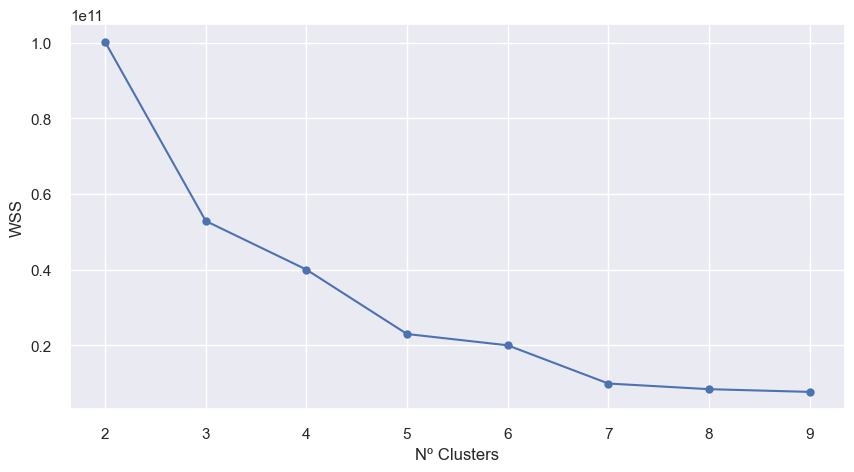

In [31]:
## Visualização performance(WSS) x nº cluster passados para algoritmo

fig, ax1 = plt.subplots(figsize = (10,5))

ax1.plot(clusters, wss, marker = 'o');

plt.xlabel("Nº Clusters");
plt.ylabel("WSS");

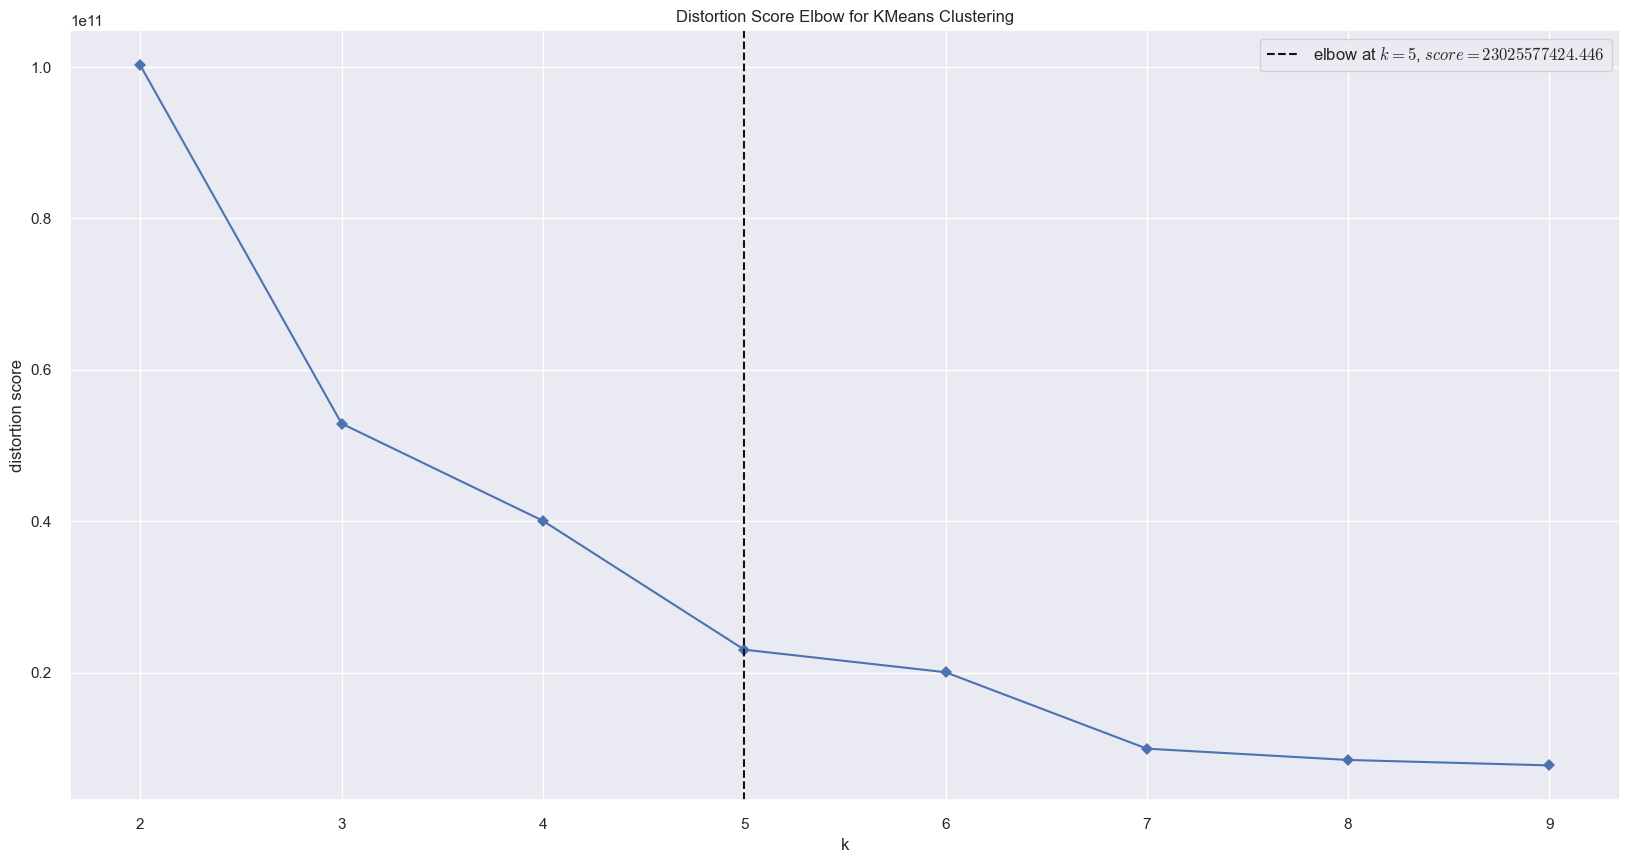

In [32]:
## Utilizando a biblioteca yellowbrick

k_means = KElbowVisualizer( ct.KMeans(init = 'random', n_clusters = k, n_init = 10, random_state = 42), k = clusters, timings = False );
k_means.fit( X );
k_means.show();

- Pela métrica WSS deveria escolher k = 5 , pois é a quantidade de cluster que faz com que a soma das distâncias dos centroídes de cada cluster com cada ponto ao quadrado resulte em um valor com considerável redução com relação a soma das distâncias dos cluster adjacentes. 

- Obviamente assumindo cluster maiores que 5 , o somatório das distâncias será menor pois irá obrigar o algoritmo a criar um novo centroíde, porém a redução de distâncias de cada ponto para o centroíde não é significativa ao ponto de justificar aumentar o número de clusters.

- Se a curva (elbow method) fosse mais suave, significa que a distribuição dos dados no espaço de features está bastante sobreposta (não há clusters naturais formados), não sendo possível a realização de agrupamentos consistentes. -> nesse caso, deve-se ajustar novo espaço de features.

## 7.2. Silhouette Score (SS)

In [33]:
ss = []

for k in clusters:
    
    # model definition 
    
    kmeans = ct.KMeans(init = 'random', n_clusters = k, n_init = 10, random_state = 42)
    
    # model fit 
    
    kmeans.fit( X )
    
    # performance 
    ss_avg = mt.silhouette_score(X, kmeans.labels_)
    ss.append( ss_avg )
    
    print(f"{k} cluster: {ss_avg}")

2 cluster: 0.9852946321467265
3 cluster: 0.9492955993916989
4 cluster: 0.8139972028952442
5 cluster: 0.772352482860595
6 cluster: 0.7041890843782485
7 cluster: 0.7053559793462968
8 cluster: 0.6716558206729113
9 cluster: 0.6266143836080639


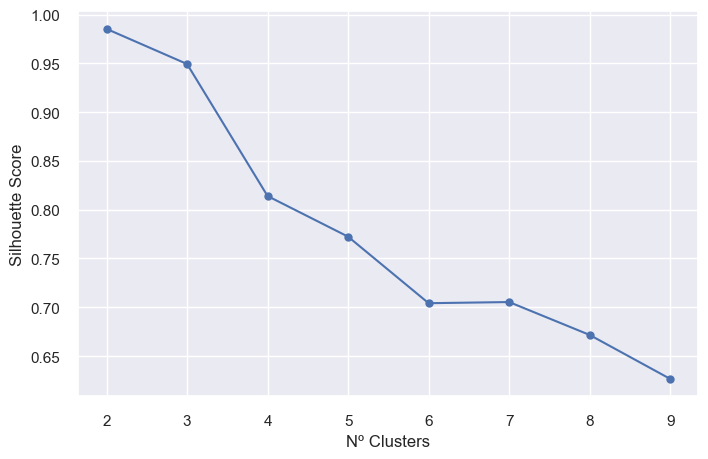

In [34]:
## Visualização performance(Silhouette Score Mean) x nº cluster passados para algoritmo

fig, ax1 = plt.subplots(figsize = (8,5))

ax1.plot(clusters, ss, marker = 'o');

plt.xlabel("Nº Clusters");
plt.ylabel("Silhouette Score");

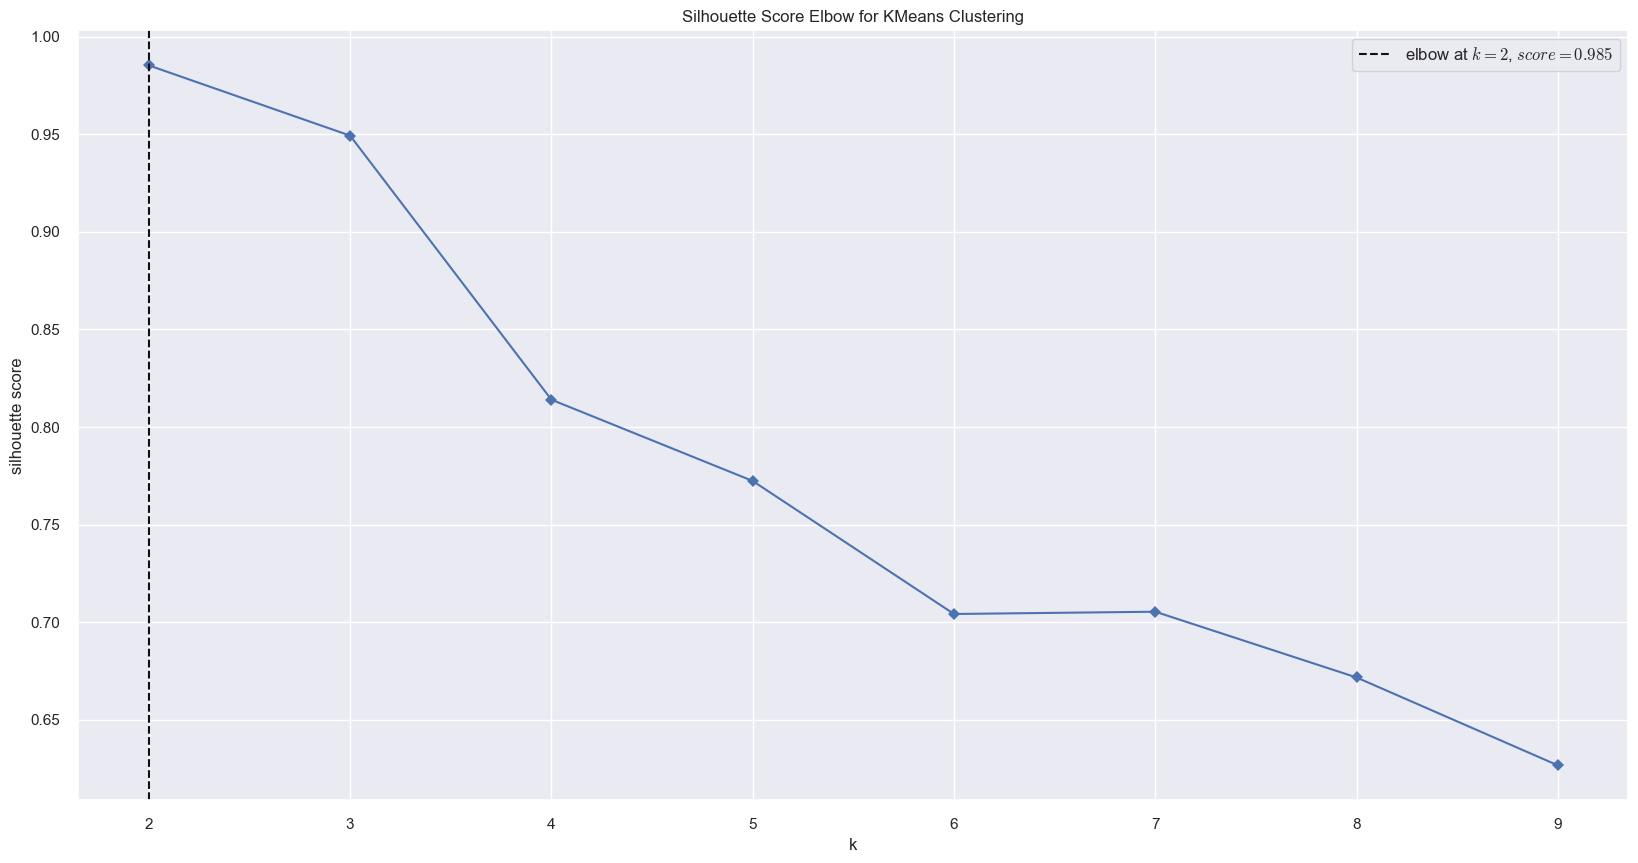

In [35]:
## Utilizando a biblioteca yellowbrick

k_means = KElbowVisualizer( ct.KMeans(init = 'random', n_clusters = k, n_init = 10, random_state = 42), k = clusters, metric = 'silhouette', timings = False );
k_means.fit( X );
k_means.show();

## 7.3. Silhouette Analysis

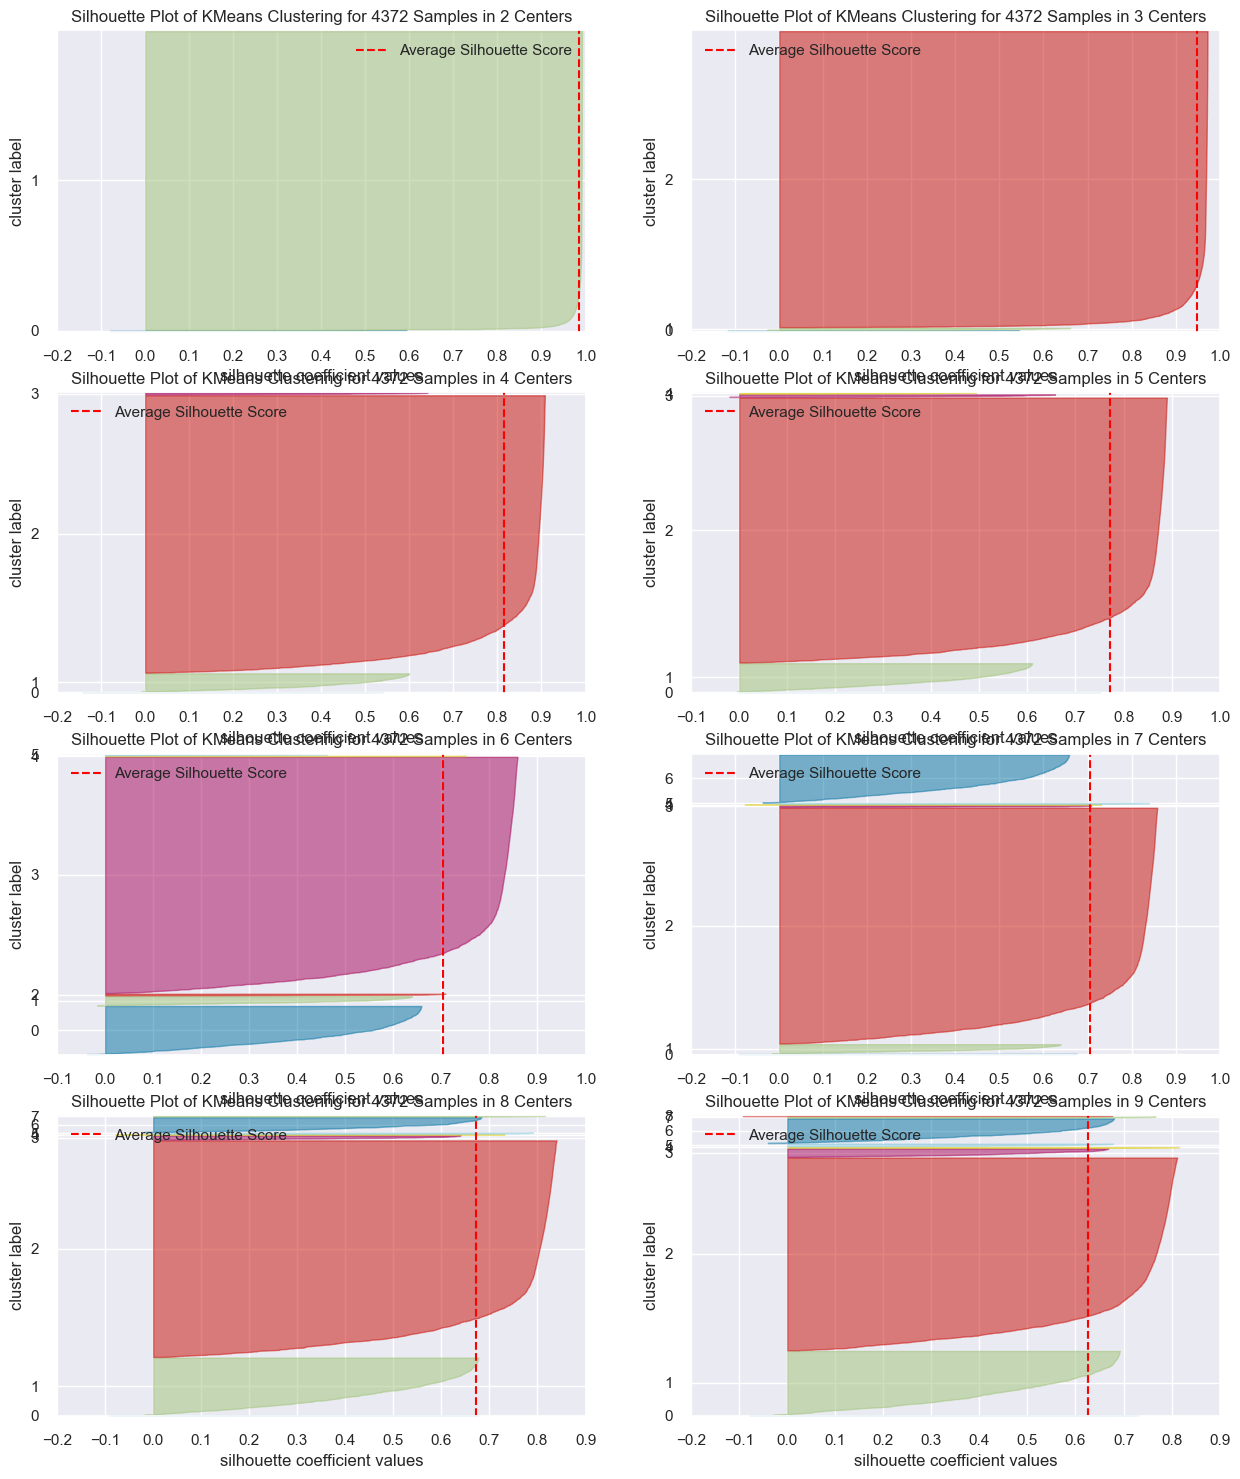

In [38]:
fig, ax = plt.subplots(4,2, figsize = (15,18))

for k in clusters:
    
    km = ct.KMeans( n_clusters=k, 
                        init='random', 
                        n_init=10, 
                        random_state=42 )
        
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(km, colors = 'yellowbrick', ax = ax[q-1, mod])
    visualizer.fit( X )
    visualizer.finalize()

Existe um cluster que possui a maioria das amostras ainda, então significa que precisa-se trabalhar mais nas features para encontrar hiperplano melhor de separação.

## 7.4. Conclusion

- Como adotou-se a métrica Silhouette Score para avaliação e ela continua melhor para 2 e 3 cluster, entende-se que a melhor segmentação (+ coeso e separado) se dá com 3 clusters. Dessa forma, o K-means será construído para clusterizar o conjunto de dados em 3 clusters.

#   8.0 Model Training 

## 8.1. K-means

In [18]:
# model definition 
k = 3
rs = 42

kmeans = ct.KMeans( n_clusters= k, 
                    init='random', 
                    n_init=10, 
                    max_iter=300,
                    random_state=rs )

# model fit 
kmeans.fit( X )

# clustering
labels = kmeans.labels_

In [19]:
## WSS (Within-Cluster Sum of Square)
print("WSS: {}".format(kmeans.inertia_))

## SS (Silhouette Score)
print("SS: {}".format( mt.silhouette_score( X, labels ) ) )

WSS: 52900059994.703865
SS: 0.9492955993916989


#  9.0 Cluster Analysis 


## 9.1. Visualization Inspection

Visualização dos cluster até 3 dimensões, se maior que 3, usar outras técnicas 

In [20]:
df9 = df7.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue_total,recency_days,frequency_total,avg_ticket_total,cluster
0,12346,0.000,325,2,0.000,2
1,12347,4310.000,2,7,23.681,2
2,12348,1797.240,75,4,57.975,2
3,12349,1757.550,18,1,24.076,2
4,12350,334.400,310,1,19.671,2


In [48]:
# fig = px.scatter_3d(df9, x = 'recency_days', y = 'frequency_total', z = 'gross_revenue_total', color = 'cluster')
# fig.show()

AttributeError: module 'plotly.validators.layout.template' has no attribute 'LayoutValidator'

In [56]:
## NÃO POSSO USAR MAIS A VISUALIZAÇÃO DOS DADOS POIS ALGORITMO ESTÁ CONSTRUÍDO COM 4 DIMENSÕES

# fig = go.Figure(data=[go.Scatter3d(x=df9['recency_days'], y=df9['frequency_total'], z=df9['gross_revenue_total'],
#                                    mode='markers', marker=dict(size=12,color=df9['cluster'],colorscale='Viridis', opacity=0.8))])
# fig.show()

## 9.2. Silhouette Analysis

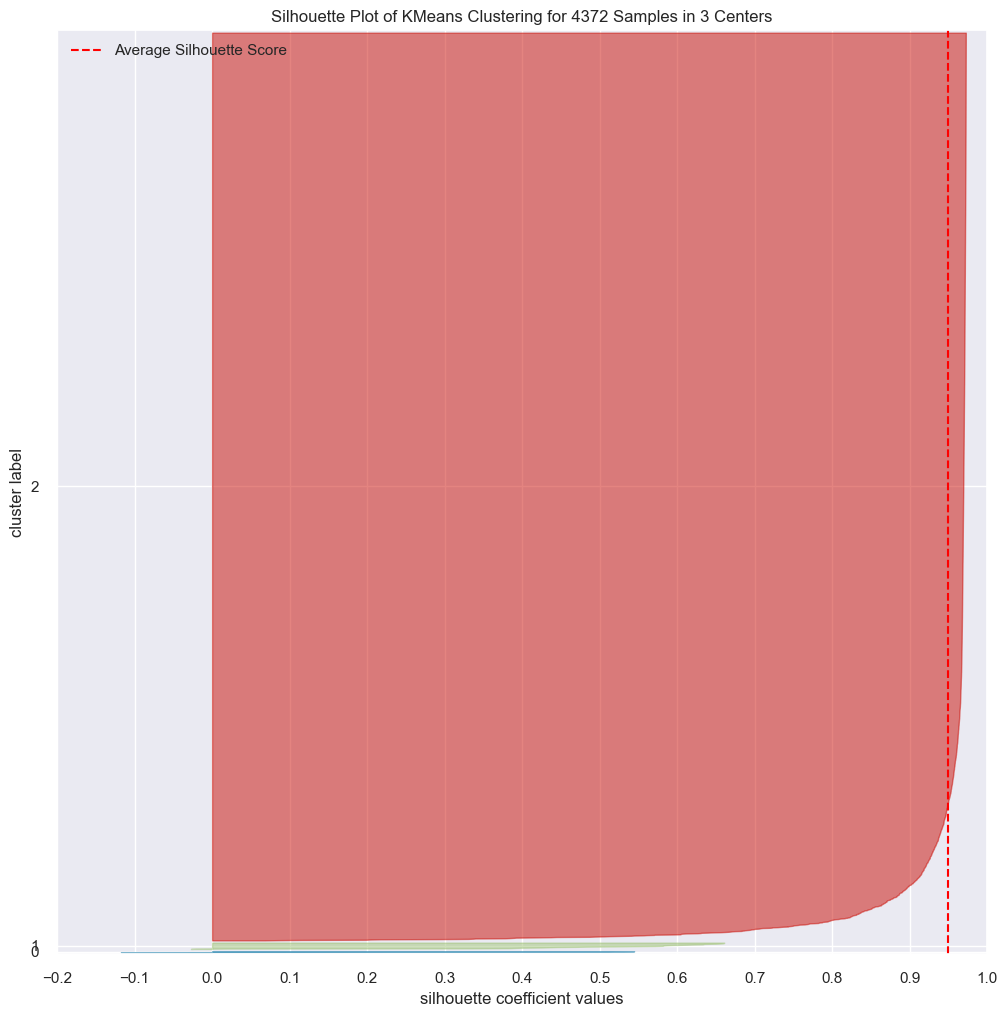

In [42]:
fig, ax1 = plt.subplots(figsize = (12,12))

kmeans = ct.KMeans( n_clusters= k,init='random', n_init=10, max_iter=300,random_state=rs )

visualizer = SilhouetteVisualizer(kmeans, colors = 'yellowbrick', ax = ax1)
visualizer.fit( X ) 
visualizer.finalize()

- Cluster 1 e 0 possuem clientes (amostras) com coeficiente de silhueta menor que 0, o que significa que essas amostras não percentem ao cluster que lhe foi atribuído.  

## 9.3. Pair plot 2d Features

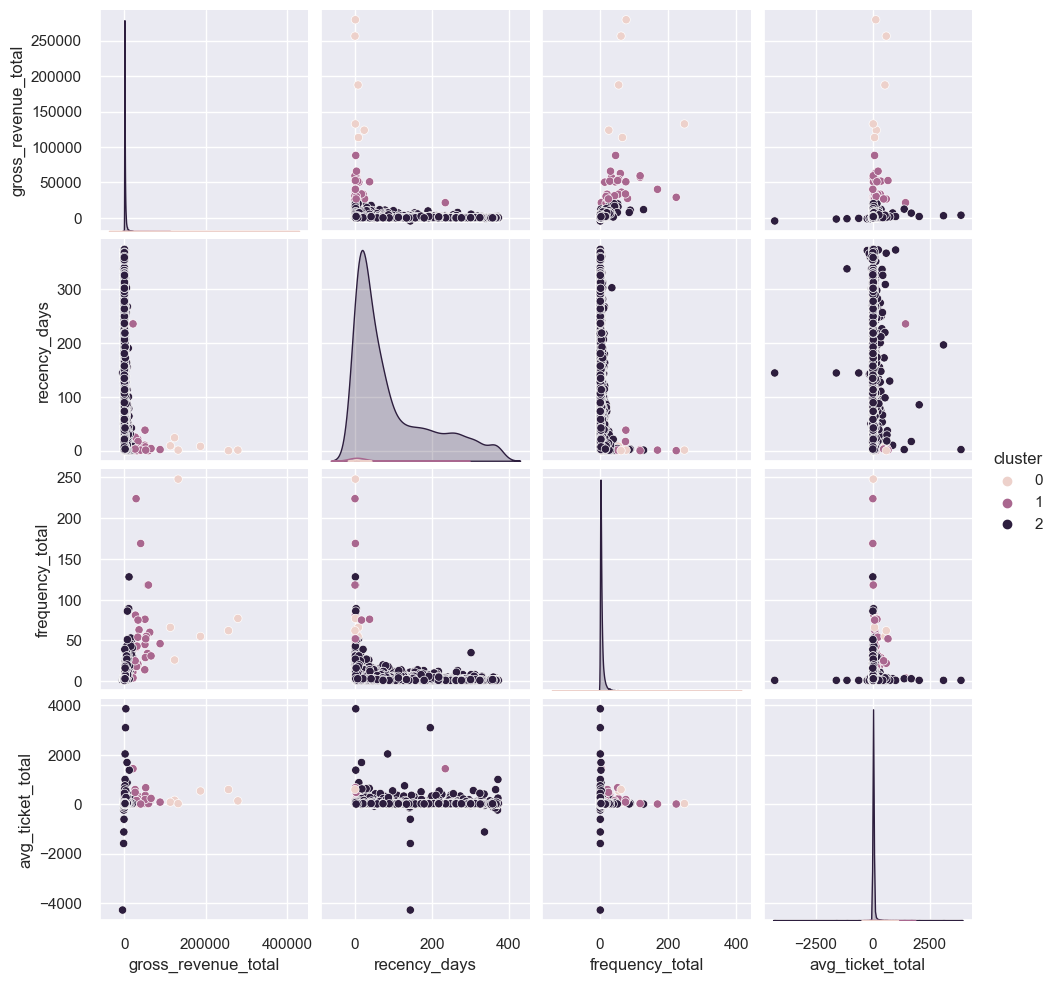

In [22]:
df_viz = df9.drop(columns = 'customer_id')

sns.pairplot(df_viz, hue = 'cluster')

Objetivo é avaliar as features que podem estar mais bagunçando do que auxiliando a criar grupos. O risco que se corre ao excluir features olhando apenas para essa visualização de cluster dois a dois é eliminar alguma feature pela aparente bagunça que causa misturada com apenas outra e ela ser uma feature relevante que em alta dimensionalidade cria clusters coesos e separados.

## 9.4. Redução de dimensionalidade com UMAP

In [23]:
## REDUÇÃO DE DIMENSIONALIDADE:

## Machine Learning - Manifold - Aprendizado por topologia
    ## Métodos UMAP - t-SNE 
## Machine Learning - Matrix - Espaço de distância - Espaço de Hilbert - 9 condições - Colorários
    ## Método PCA 

# reducer = projeção de alta dimensionalidade
reducer = umap.UMAP(random_state = 42)

# embedding = espaço projetado em 2D
embedding = reducer.fit_transform( X )

df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

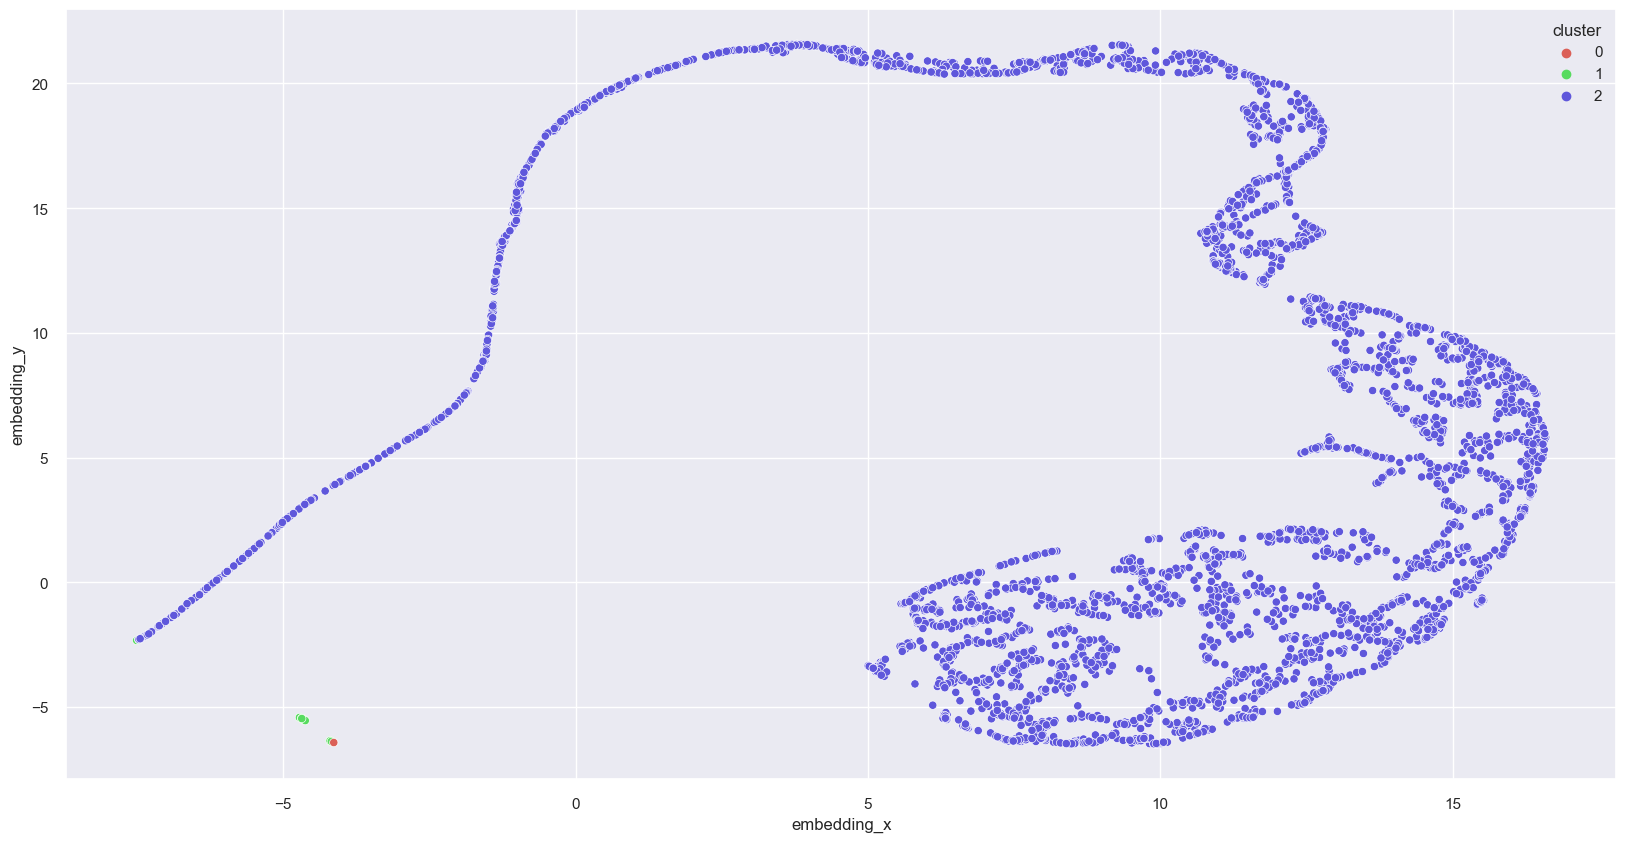

In [24]:
# plot embedding - clusters projetados de alta dimensionalidade

sns.scatterplot(x = 'embedding_x', y = 'embedding_y', hue = 'cluster', palette = sns.color_palette('hls', n_colors = df_viz['cluster'].nunique()),
                data = df_viz );

**Interpretação:** não significa que em alta dimensionalidade os cluster estão nessa distância um do outro, como é uma projeção, possui o intuito  de verificar se no espaço projetado existem cluster misturados, assim sendo, existe uma alta probabilidade de estarem também no espaço de alta dimensionalidade.

## 9.5. Cluster Profile

In [27]:
## Number of customer 

df_cluster = df9[['customer_id','cluster']].groupby(by = 'cluster').count().reset_index().rename(columns = {'customer_id':'n_customer'})
df_cluster['perc_customer'] = 100 * (df_cluster['n_customer'] / df_cluster['n_customer'].sum())


## Avg gross_revenue_total
df_reve = df9[['gross_revenue_total','cluster']].groupby(by = 'cluster').mean().reset_index().rename(columns = {'gross_revenue_total':'mean_revenue_total'})

## Avg recency_days 
df_rece = df9[['recency_days','cluster']].groupby(by = 'cluster').mean().reset_index().rename(columns = {'recency_days':'mean_recency_days'})

## Avg frequency_total
df_freq = df9[['frequency_total','cluster']].groupby(by = 'cluster').mean().reset_index().rename(columns = {'frequency_total':'mean_frequency_total'})

## Avg avg_ticket 
df_ticket = df9[['avg_ticket_total','cluster']].groupby(by = 'cluster').mean().reset_index().rename(columns = {'avg_ticket_total':'mean_ticket_total'})

## join tables
df_c_profile = df_cluster.merge(df_reve, on = 'cluster', how = 'left').merge(df_rece, on = 'cluster', how = 'left').merge(df_freq, on = 'cluster', how = 'left').merge(df_ticket, on = 'cluster', how = 'left')

df_c_profile


,cluster,n_customer,perc_customer,mean_revenue_total,mean_recency_days,mean_frequency_total,mean_ticket_total
0,0,6,0.137,182181.982,7.167,89.000,253.626
1,1,31,0.709,40543.518,13.290,53.290,201.894
2,2,4335,99.154,1372.578,92.258,4.615,27.290


**Relatório:**

### CLUSTER 0: (Candidato à Insiders)

        - Quantidade de clientes: 6 (0,14%)
        - Média de faturamento total gerado: US 182.181,9 
        - Média da recência: 7,167 dias
        - Média de transações no período total: 89 
        - Média do ticket médio: US 253,6

### CLUSTER 1:

        - Quantidade de clientes: 31 (0,71%)
        - Média de faturamento total gerado: US 40.543,5 
        - Média da recência: 13,3 dias
        - Média de transações no período total: 53,29
        - Média do ticket médio: US 201,9

### CLUSTER 2:

        - Quantidade de clientes: 4.335 (99,15%)
        - Média de faturamento total gerado: US 1.372,6 
        - Média da recência: 92,25 dias
        - Média de transações no período total: 4,6
        - Média do ticket médio: US 27,3

**Análise:**

- Quantidade de amostras em cada cluster muito desequilibrada

# <font color = 'red'>  10.0 Deploy to production </font>